# Australian Weather Forecasting - Imputing Data

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import theano
import theano.tensor as tt
import itertools
import matplotlib.pyplot as plt
import scipy.stats as scistat
import arviz as az
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import scipy as sp

## Loading Data

In [2]:
aussy_Rain = pd.read_csv('../data/weather_imputed.csv')

## Preprocessing 

### Convert our Date column into datetime object

In [3]:
aussy_Rain['Date']=pd.to_datetime(aussy_Rain['Date'])

### Convert Date into Season 
Thanks to https://stackoverflow.com/questions/44124436/python-datetime-to-season 

In [4]:
[(month%12 + 3)//3 for month in range(1, 13)]

[1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]

Where, in Australia: http://www.bom.gov.au/climate/glossary/seasons.shtml  
* Month 1 = Summer
* Month 2 = Autumn
* Month 3 = Winter
* Month 4 = Spring

In [5]:
aussy_Rain['Date'] = (aussy_Rain.Date.dt.month%12 + 3)//3

In [6]:
aussy_Rain['Date']

0       3
1       2
2       4
3       3
4       2
       ..
2995    1
2996    3
2997    4
2998    2
2999    1
Name: Date, Length: 3000, dtype: int64

In [7]:
num_locations = aussy_Rain.groupby('Location').apply(len)

### Dummy encoding for other Categoricals

In [8]:
encoding = dict()
for column in aussy_Rain:
    if aussy_Rain[column].dtype == object:
        unique = aussy_Rain[column].unique()
        encoding[column] = {name: index for index, name in enumerate(unique)}
aussy_Rain = aussy_Rain.replace(encoding)

Remove RISK_MM (kaggle dataset authors say this variable should be removed)

In [37]:
aussy_Rain = aussy_Rain.drop(['RISK_MM'], axis=1)

## Preliminary Visualization

### Visualize model with priors

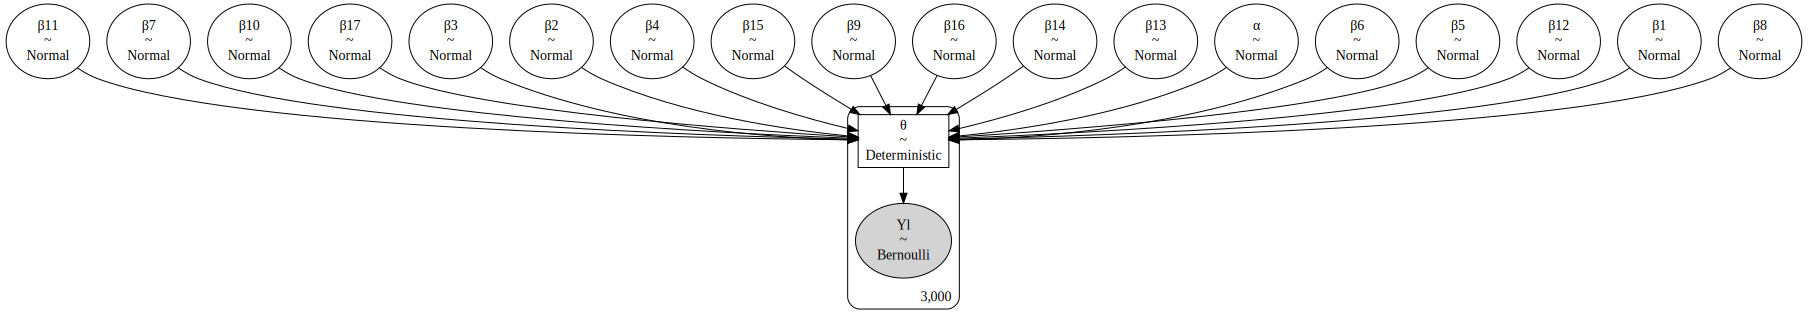

In [10]:
#### Posterior Distribution of parameters# Use pm.find_MAP() to find the maximum a-posteriori (MAP) estimate for the vector of regression coefficients .

with pm.Model() as manual_logistic_model:
    Y = aussy_Rain["RainTomorrow"]
    α = pm.Normal('α', mu=0, sd=100) 
    β1 = pm.Normal('β1', mu=0, sd=100) 
    β2 = pm.Normal('β2', mu=0, sd=100) 
    β3 = pm.Normal('β3', mu=0, sd=100) 
    β4 = pm.Normal('β4', mu=0, sd=100)
    β5 = pm.Normal('β5', mu=0, sd=100) 
    β6 = pm.Normal('β6', mu=0, sd=100)
    β7 = pm.Normal('β7', mu=0, sd=100) 
    β8 = pm.Normal('β8', mu=0, sd=100)
    β9 = pm.Normal('β9', mu=0, sd=100)
    β10 = pm.Normal('β10', mu=0, sd=100)
    β11 = pm.Normal('β11', mu=0, sd=100)
    β12 = pm.Normal('β12', mu=0, sd=100)
    β13 = pm.Normal('β13', mu=0, sd=100)
    β14 = pm.Normal('β14', mu=0, sd=100)
    β15 = pm.Normal('β15', mu=0, sd=100)
    β16 = pm.Normal('β16', mu=0, sd=100)
    β17 = pm.Normal('β17', mu=0, sd=100)


    μ = α + pm.math.dot(aussy_Rain["MinTemp"], β1) + pm.math.dot(aussy_Rain["MaxTemp"],β2) + pm.math.dot(aussy_Rain["Rainfall"], β3) + pm.math.dot(aussy_Rain["WindGustSpeed"],β4) + pm.math.dot(aussy_Rain["WindSpeed9am"], β5) + pm.math.dot(aussy_Rain["WindSpeed3pm"],β6) + pm.math.dot(aussy_Rain["Humidity9am"], β7) + pm.math.dot(aussy_Rain["Humidity3pm"],β8) + pm.math.dot(aussy_Rain["Pressure9am"], β9) + pm.math.dot(aussy_Rain["Pressure3pm"], β10) + pm.math.dot(aussy_Rain["Pressure9am"], β11) + pm.math.dot(aussy_Rain["Location"], β12) + pm.math.dot(aussy_Rain["WindGustDir"],β13) + pm.math.dot(aussy_Rain["WindDir9am"],β14) + pm.math.dot(aussy_Rain["WindDir3pm"],β15) + pm.math.dot(aussy_Rain["RainToday"],β16) + pm.math.dot(aussy_Rain["Date"], β17) 
    θ = pm.Deterministic('θ',  pm.invlogit(μ))
    Yl = pm.Bernoulli('Yl', p=θ, observed=Y) 
    map_estimate = pm.find_MAP()
    #print(map_estimate)
pm.model_to_graphviz(manual_logistic_model)

### MAP ESTIMATE FOR Parameters (Logistic)

In [11]:
map_estimate

{'α': array(0.65795363),
 'β1': array(-0.14066223),
 'β2': array(0.17508112),
 'β3': array(-0.04812784),
 'β4': array(-0.21247675),
 'β5': array(-0.18769728),
 'β6': array(0.1799282),
 'β7': array(-0.01010237),
 'β8': array(-0.65818903),
 'β9': array(-0.1250757),
 'β10': array(0.1910013),
 'β11': array(-0.1250757),
 'β12': array(0.00234107),
 'β13': array(-0.02841101),
 'β14': array(0.01734375),
 'β15': array(-0.01636066),
 'β16': array(1.13371125),
 'β17': array(0.02891356),
 'θ': array([0.50150476, 0.48893806, 0.8675258 , ..., 0.89609348, 0.93095911,
        0.94298824])}

## Building Models

### Logistic Regression (full model)

In [52]:
with pm.Model() as logistic_model:
        pm.glm.GLM.from_formula('RainTomorrow ~ MinTemp + MaxTemp + Rainfall + WindGustSpeed + WindSpeed9am + WindSpeed3pm + Humidity9am + Humidity3pm + Pressure9am + Pressure3pm + Temp9am + Temp3pm + Location + WindGustDir + WindDir9am + WindDir3pm + RainToday + Date', aussy_Rain, family=pm.glm.families.Binomial())
        trace = pm.sample(1000, tune=1000, cores=4, init='adapt_diag', target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Date, RainToday, WindDir3pm, WindDir9am, WindGustDir, Location, Temp3pm, Temp9am, Pressure3pm, Pressure9am, Humidity3pm, Humidity9am, WindSpeed3pm, WindSpeed9am, WindGustSpeed, Rainfall, MaxTemp, MinTemp, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 218 seconds.


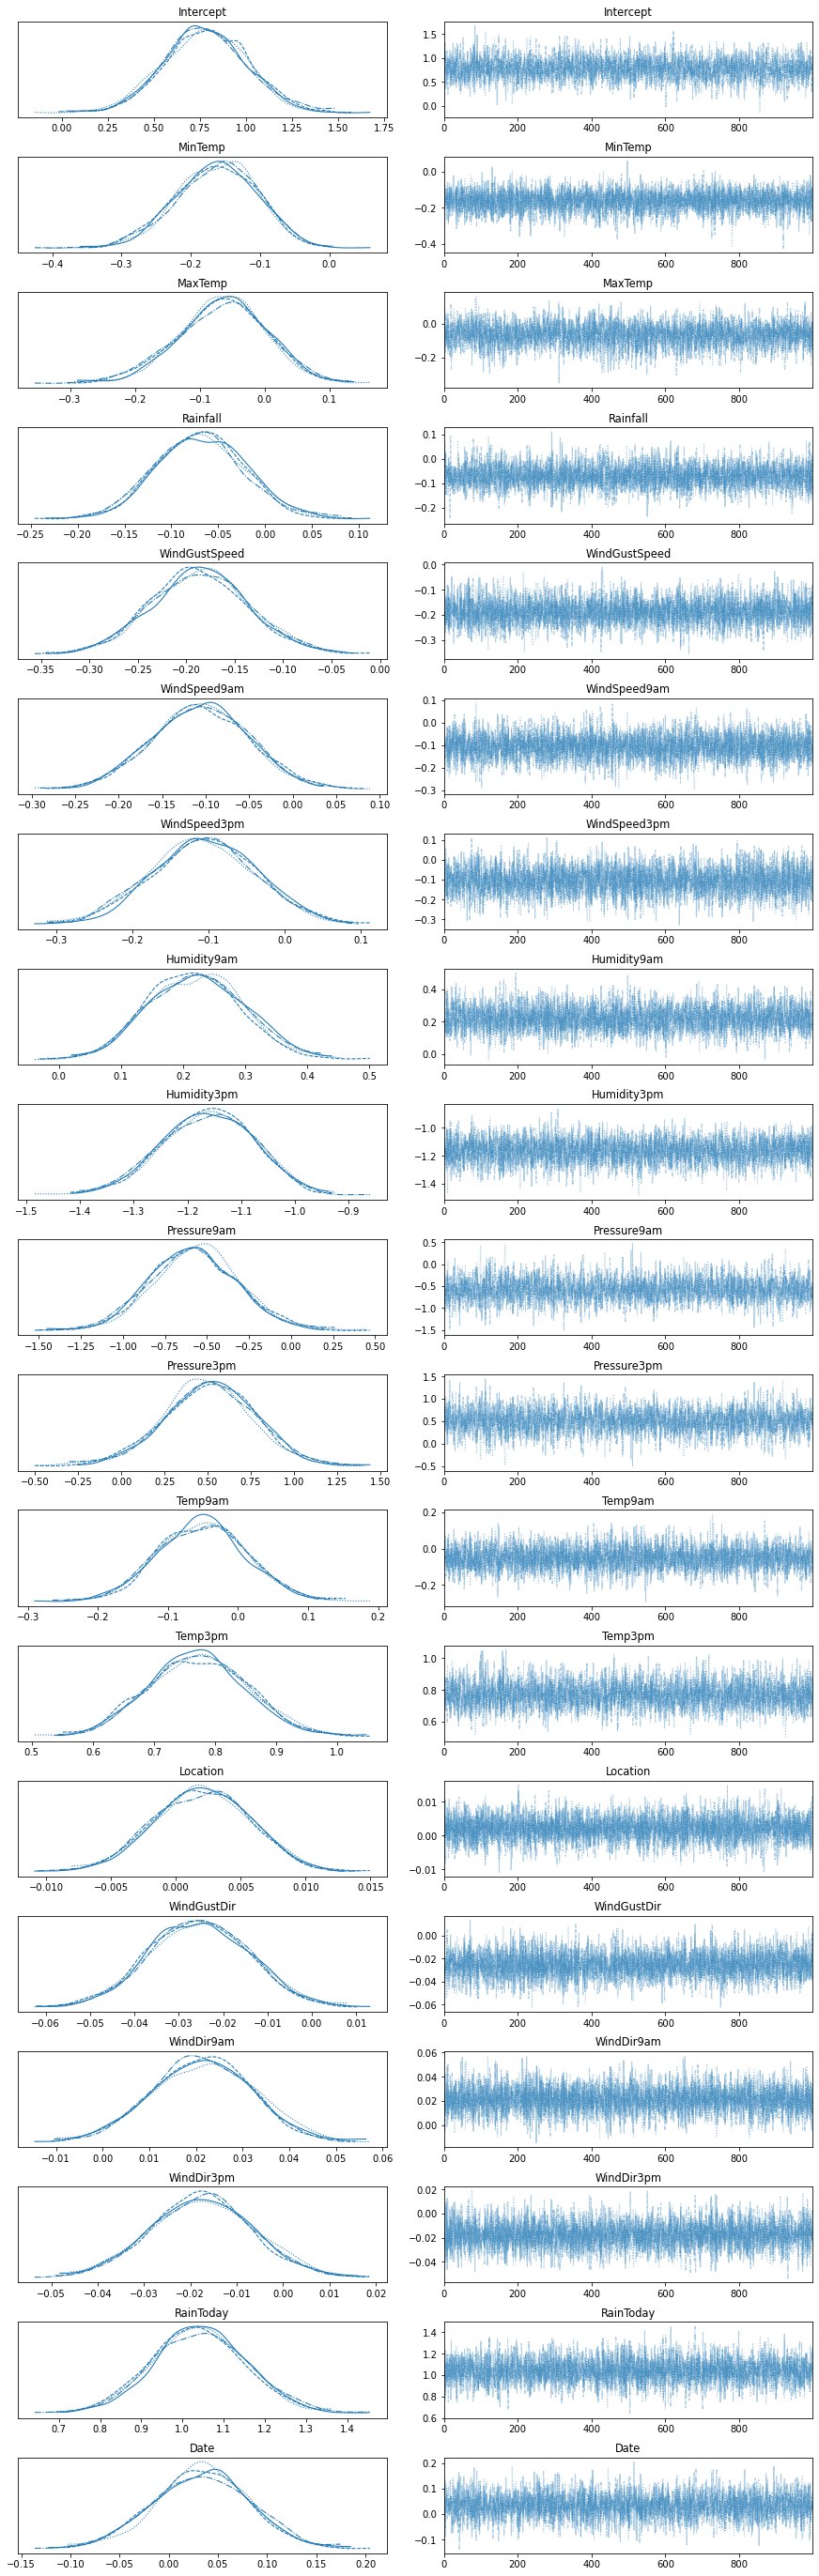

In [13]:
with pm.Model() as logistic_model:
    pm.traceplot(trace)

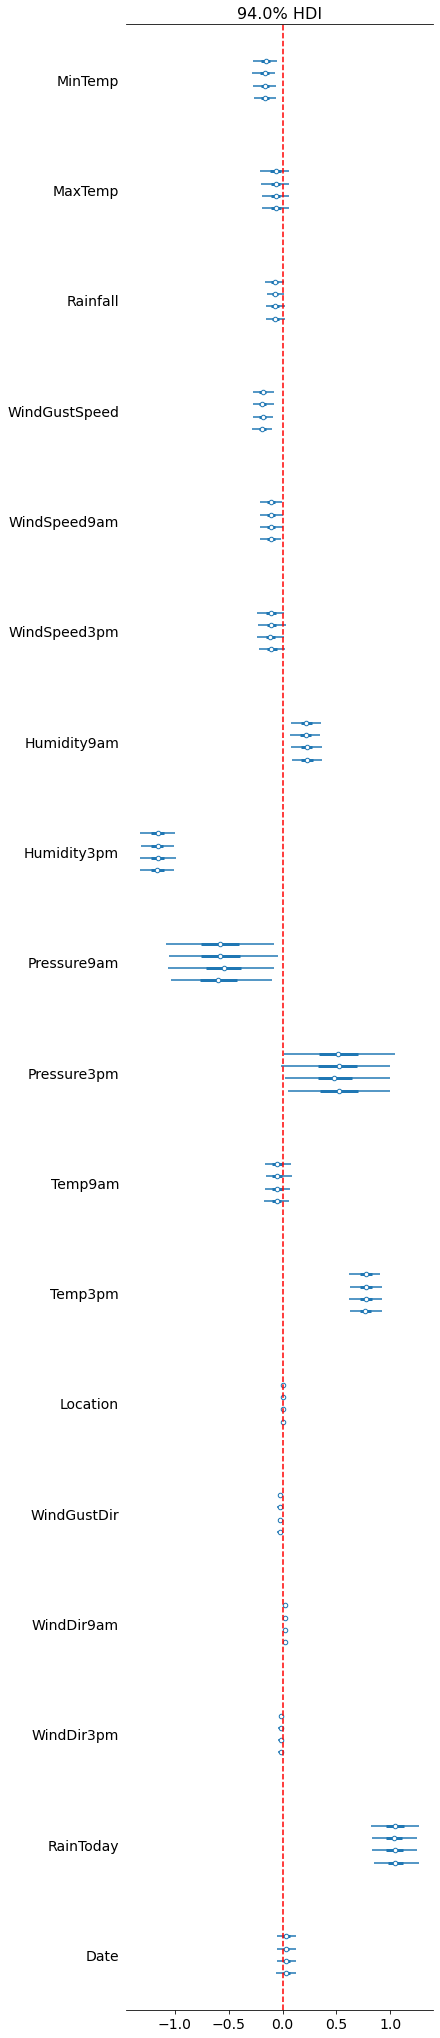

In [14]:
with pm.Model() as logistic_model:
    az.plot_forest(trace, var_names="~Intercept")
plt.axvline(0,color='r',linestyle='dashed')
plt.show()

### Partial Logistic Regression

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [RainToday, Temp3pm, Pressure3pm, Pressure9am, Humidity3pm, Humidity9am, WindSpeed3pm, WindSpeed9am, WindGustSpeed, Rainfall, MinTemp, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 123 seconds.


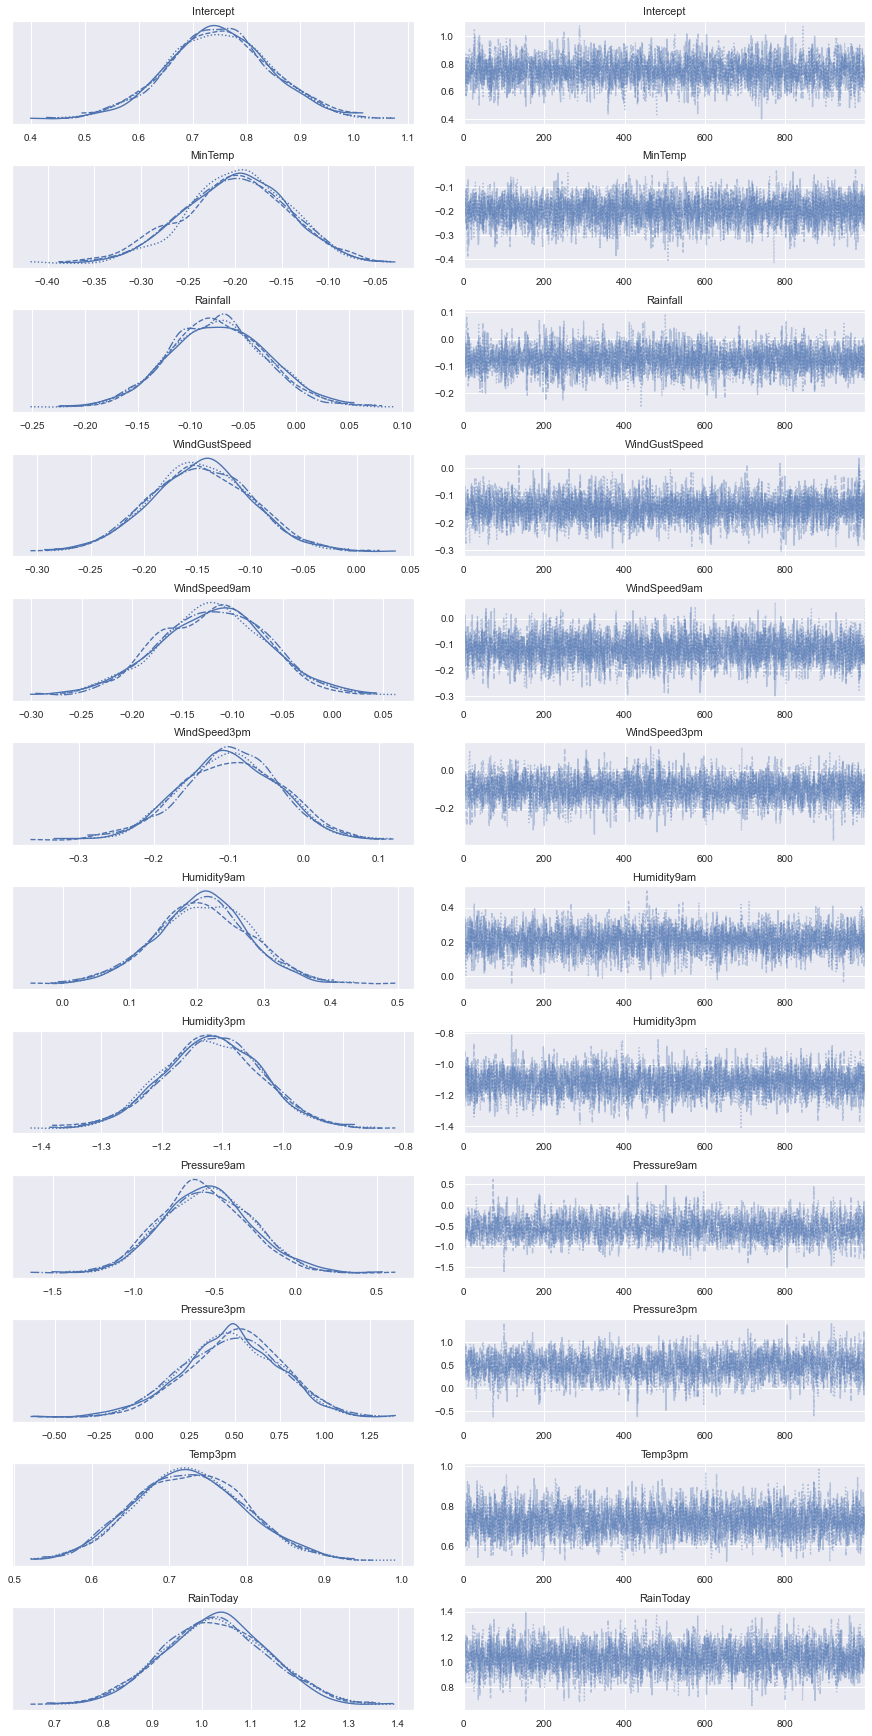

In [38]:

with pm.Model() as logistic_model:
        Y = aussy_Rain.RainTomorrow
        pm.glm.GLM.from_formula('Y ~ MinTemp  + Rainfall + WindGustSpeed + WindSpeed9am + WindSpeed3pm + Humidity9am + Humidity3pm + Pressure9am + Pressure3pm + Temp3pm + RainToday', aussy_Rain, family=pm.glm.families.Binomial())
        partial_trace = pm.sample(1000, tune=1000, cores=4, init='adapt_diag', target_accept=0.95)
with pm.Model() as partial_logistic_model:
    pm.traceplot(partial_trace)

### Unpooled Model

In [15]:
Local = aussy_Rain.Location.unique()
locations = len(Local)
Location_lookup = dict(zip(Local, range(len(Local))))
location_Code = aussy_Rain['Location'] = aussy_Rain.Location.replace(Location_lookup).values 
print(aussy_Rain['Location'])

0        0
1        1
2        2
3        3
4        4
        ..
2995     9
2996     5
2997     6
2998    45
2999     8
Name: Location, Length: 3000, dtype: int64


In [16]:
aussy_X = aussy_Rain[[column for column in aussy_Rain.columns if column != 'RainTomorrow']]
Rainfall = aussy_Rain['Humidity3pm']
RainTomorrow =aussy_Rain['RainTomorrow']

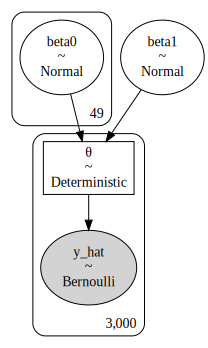

In [17]:
with pm.Model() as unpooled_model:
    beta0 = pm.Normal('beta0', 0, sd=1e5, shape=locations)
    beta1 = pm.Normal('beta1', 0, sd=100)
    mu = beta0[location_Code] + beta1*Rainfall
    θ = pm.Deterministic('θ',  pm.invlogit(mu))
    y_hat = pm.Bernoulli('y_hat', p=θ, observed=RainTomorrow) 

pm.model_to_graphviz(unpooled_model)

In [18]:
with unpooled_model:
    unpooled_trace = pm.sample(1000, cores = 4, tune=1000)
    unpooled_idata = az.from_pymc3(unpooled_trace)
az.summary(unpooled_idata, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta0[0],0.99,0.34,0.34,1.61,0.0,0.0,9340.18,6829.82,9494.57,3109.48,1.0
beta0[1],1.52,0.41,0.76,2.26,0.0,0.0,8087.61,6218.98,8419.37,2881.93,1.0
beta0[2],1.42,0.36,0.75,2.11,0.0,0.0,11179.63,8541.29,11431.79,3029.35,1.0
beta0[3],1.46,0.28,0.89,1.97,0.0,0.0,8870.50,8020.20,8865.26,2829.61,1.0
beta0[4],1.11,0.31,0.53,1.66,0.0,0.0,9272.72,7400.02,9278.96,3004.20,1.0
...,...,...,...,...,...,...,...,...,...,...,...
θ[2995],0.77,0.06,0.65,0.88,0.0,0.0,8696.65,8696.65,8790.97,2671.66,1.0
θ[2996],0.86,0.05,0.76,0.94,0.0,0.0,8855.66,8855.66,9112.47,2820.35,1.0
θ[2997],0.87,0.04,0.80,0.94,0.0,0.0,8969.64,8969.64,9004.22,3042.88,1.0
θ[2998],0.93,0.04,0.86,0.99,0.0,0.0,6705.83,6705.83,6992.06,2692.46,1.0


In [19]:
estimate_unpool = pd.Series(unpooled_trace['beta0'].mean(axis=0), index=Location_lookup)
se_unpool = pd.Series(unpooled_trace['beta0'].std(axis=0), index=Location_lookup)

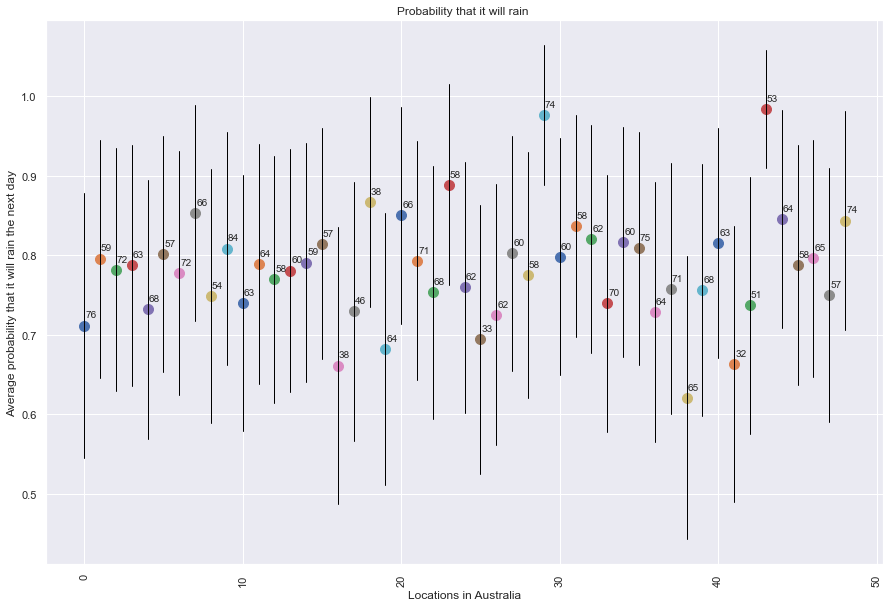

In [20]:
import seaborn as sns
sns.set()

def sigmoid(x):
    return ( 1 / (1+ np.exp(-x)))
m_list = list()
stdev_list = list()
beta0 = np.mean(unpooled_trace['beta0'], axis=0)
beta1 = np.mean(unpooled_trace['beta1'], axis=0)
fig_unpooled = plt.figure(figsize = (15,10))
plt.title("Probability that it will rain ")
for num,beta0i in enumerate(beta0):
    m = np.mean(sigmoid(beta0i + beta1*Rainfall),axis=0); m_list.append(m)
    stdev = np.std(sigmoid(beta0i+beta1*Rainfall),axis=0); stdev_list.append(stdev)
    plt.scatter(Location_lookup[num], m,s=100)
    plt.plot([Location_lookup[num],Location_lookup[num]],[m+stdev,m-stdev],'black',linewidth=1)
plt.xticks(rotation=90)
for i, txt in enumerate(num_locations):
    plt.annotate(txt, (Location_lookup[i],m_list[i]),xytext=(1, 8),textcoords="offset points",fontsize=10)
plt.ylabel('Average probability that it will rain the next day');plt.xlabel('Locations in Australia');
plt.show();

### Hierachical Model 

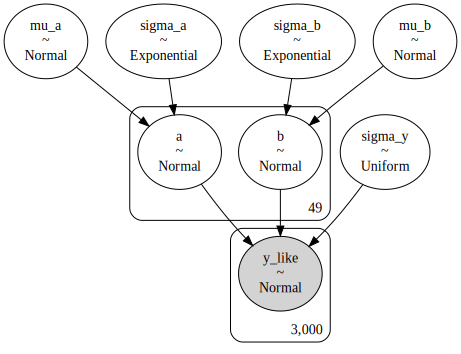

In [21]:
with pm.Model() as intercept_model:
    #Priors
    mu_a = pm.Normal('mu_a', mu=0., sd=100)
    sigma_a = pm.Exponential("sigma_a", 0.5)
    mu_b = pm.Normal('mu_b', mu=0., sd=100)
    sigma_b = pm.Exponential("sigma_b", .5)

    #Intercept, Random
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=locations)
    # Random slopes
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=locations)
    #Error
    sigma_y = pm.Uniform('sigma_y', lower=0, upper=100)
    #E(X)
    y_hat = a[location_Code] + b[location_Code] * Rainfall
    #Likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sd=sigma_y, observed=RainTomorrow)
    
pm.model_to_graphviz(intercept_model)

In [22]:
with intercept_model:
    intercept_model_trace = pm.sample(3500, step = pm.NUTS(target_accept = 0.999), cores = 4, tune=1000)
    intercept_model_idata = az.from_pymc3(intercept_model_trace)
az.summary(intercept_model_idata, round_to=2)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 3_500 draw iterations (4_000 + 14_000 draws total) took 391 seconds.
The number of effective samples is smaller than 10% for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_a,0.77,0.01,0.75,0.79,0.0,0.0,6010.16,6010.16,6013.46,9223.95,1.0
mu_b,-0.23,0.02,-0.27,-0.19,0.0,0.0,11542.56,11361.27,11580.56,9413.07,1.0
a[0],0.74,0.04,0.67,0.80,0.0,0.0,6505.86,6505.86,6618.84,9739.69,1.0
a[1],0.75,0.04,0.69,0.82,0.0,0.0,10888.46,10888.46,11210.39,9779.00,1.0
a[2],0.77,0.03,0.71,0.84,0.0,0.0,13853.75,13726.09,13804.56,10008.91,1.0
...,...,...,...,...,...,...,...,...,...,...,...
b[47],-0.19,0.05,-0.29,-0.08,0.0,0.0,13126.72,11894.63,13155.50,10294.95,1.0
b[48],-0.20,0.06,-0.31,-0.10,0.0,0.0,15588.01,15066.29,15606.86,9700.96,1.0
sigma_a,0.04,0.01,0.02,0.07,0.0,0.0,823.58,823.58,891.31,576.82,1.0
sigma_b,0.12,0.02,0.09,0.15,0.0,0.0,8862.03,8862.03,8715.98,9481.63,1.0


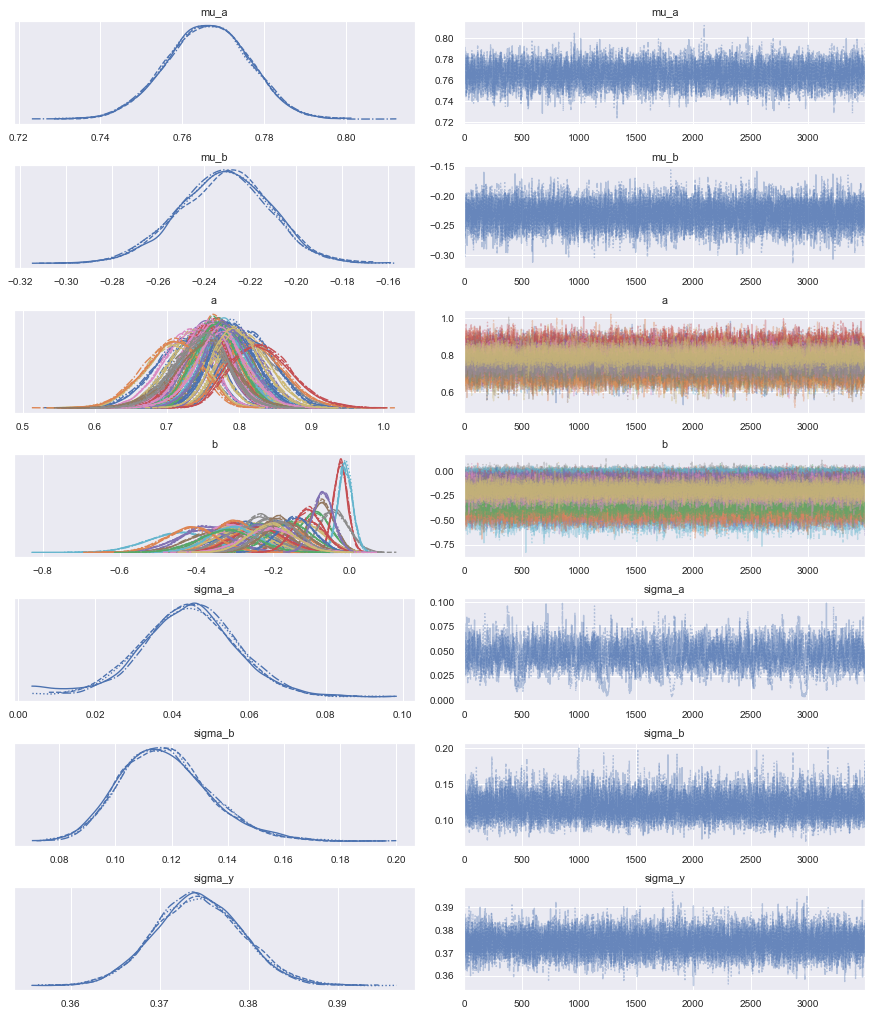

In [23]:
with intercept_model:
    pm.traceplot(intercept_model_trace)

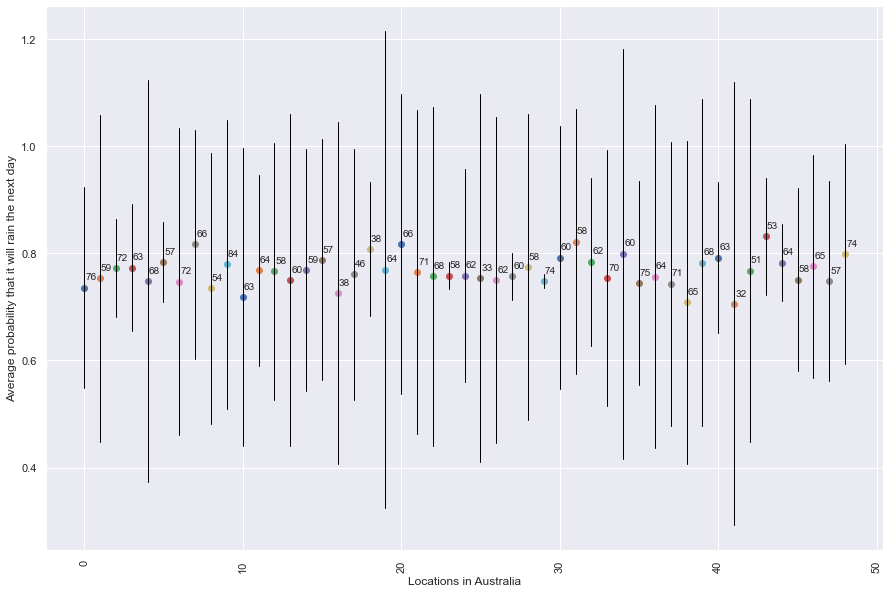

In [24]:
import seaborn as sns
sns.set()
m_list = list()
stdev_list = list()
a = np.mean(intercept_model_trace['a'], axis=0)
b = np.mean(intercept_model_trace['b'], axis=0)
fig_hierarchical = plt.figure(figsize = (15,10))
for num,(ai,bi) in enumerate(zip(a,b)):
    m = np.mean(ai+bi*Rainfall,axis=0)
    m_list.append(m)
    stdev = np.std(ai+bi*Rainfall,axis=0)
    stdev_list.append(stdev)
    plt.scatter(Location_lookup[num], m)
    plt.plot([Location_lookup[num],Location_lookup[num]],[m+stdev,m-stdev],'black',linewidth=1)
plt.xticks(rotation=90)
plt.ylabel('Average probability that it will rain the next day');plt.xlabel('Locations in Australia');
for i, txt in enumerate(num_locations):
    plt.annotate(txt, (Location_lookup[i],m_list[i]),xytext=(1, 8),textcoords="offset points",fontsize=10)
plt.ylabel('Average probability that it will rain the next day');plt.xlabel('Locations in Australia');
plt.show();
plt.show();


In [25]:
intercept_model_trace['a']

array([[0.72269954, 0.76946136, 0.83041394, ..., 0.8291801 , 0.80131774,
        0.83615655],
       [0.68948093, 0.78740604, 0.83329925, ..., 0.81257384, 0.80068018,
        0.80793386],
       [0.74118286, 0.82452729, 0.73995726, ..., 0.78433043, 0.79844728,
        0.80562514],
       ...,
       [0.7039982 , 0.76492383, 0.77463258, ..., 0.78275806, 0.76565676,
        0.79436401],
       [0.75968428, 0.77851901, 0.78343985, ..., 0.77342552, 0.76420699,
        0.74099178],
       [0.74278258, 0.77618788, 0.80158496, ..., 0.77938952, 0.72643329,
        0.83090216]])

### Variational Sampling (Git Push)

In [26]:
SEED = 12345 
np.random.seed(SEED)

In [27]:
with intercept_model:
    approx = pm.fit(50000, method = 'advi', random_seed = SEED)

Finished [100%]: Average Loss = 1,398.5


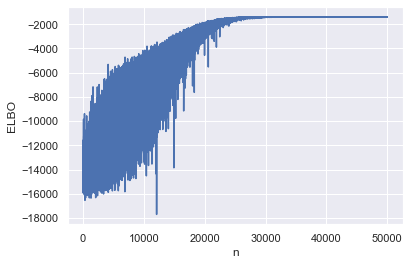

In [28]:
advi_elbo = pd.DataFrame(
    {'ELBO': -approx.hist,
     'n': np.arange(approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)


In [29]:
PPC_SAMPLES = 4000
advi_trace = approx.sample(PPC_SAMPLES)
advi_trace

<MultiTrace: 1 chains, 4000 iterations, 10 variables>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb960044ee0>,
      dtype=object)

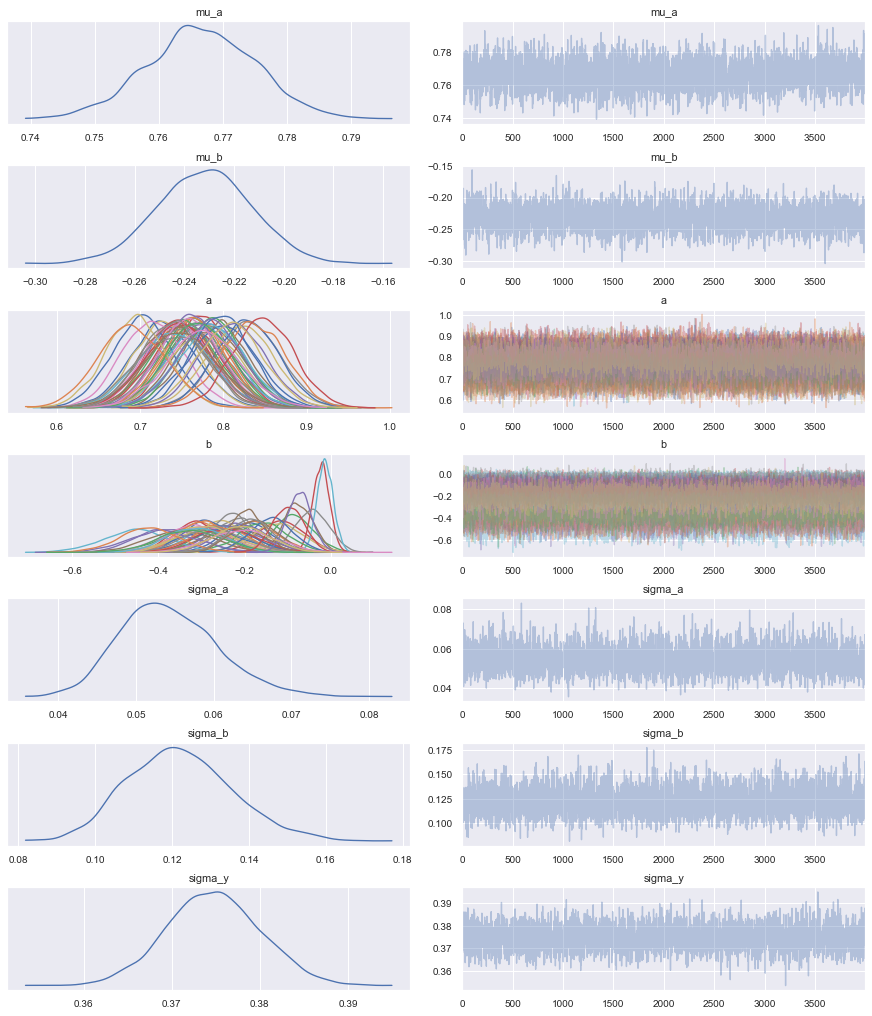

In [30]:
pm.traceplot(advi_trace)

In [31]:
pm.summary(advi_trace)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_a,0.767,0.009,0.750,0.782,0.000,0.000,3953.0,3952.0,3954.0,3763.0,NaN
mu_b,-0.232,0.019,-0.267,-0.196,0.000,0.000,3218.0,3206.0,3213.0,3623.0,NaN
a[0],0.728,0.039,0.656,0.803,0.001,0.000,3863.0,3863.0,3868.0,3687.0,NaN
a[1],0.750,0.040,0.676,0.825,0.001,0.000,4209.0,4209.0,4211.0,3624.0,NaN
a[2],0.773,0.040,0.698,0.847,0.001,0.000,3893.0,3893.0,3889.0,3840.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
b[47],-0.187,0.052,-0.283,-0.089,0.001,0.001,4014.0,3964.0,4012.0,3679.0,NaN
b[48],-0.208,0.065,-0.326,-0.081,0.001,0.001,3754.0,3685.0,3761.0,3802.0,NaN
sigma_a,0.054,0.006,0.043,0.066,0.000,0.000,4013.0,4013.0,3994.0,3802.0,NaN
sigma_b,0.122,0.014,0.097,0.148,0.000,0.000,3998.0,3998.0,3966.0,3662.0,NaN


In [47]:
cmp_df = az.compare({'full_model':trace, 'partial_model':partial_trace})
model_names = ['partial_model','full_model']
trace = [partial_trace, trace]
models = [logistic1,logistic_red1,logistic_red2]